### 1. 분석 목표와 데이터 확인

* 분석할 주제 및 문제 정의
    - 서울페이 활성화를 위한 방안

* 분석 목표 수립 및 가설 설정
    - 서울페이 동/업종별 결제 기록을 분석하여 인사이트 도출

* 필요한 데이터 종류 및 출처, 수집 방식
    - 정형 : csv(공공데이터 포털) - 다운로드

### 2. 데이터 로딩 및 구조 파악

* 데이터 로딩

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import folium as fo

data = pd.read_excel('data/서울페이_행정동별_업종별 결제현황(24.6).xlsx')

* 데이터 개요 및 데이터 타입 확인
    - head(), info() 

In [55]:
data.head()

,서울페이앱분류업종,자치구,상품권매출금액\n(24년1월~24년6월),상품권거래건수\n(24년1월~24년6월)
0,기타,중구,3583515256,192005
1,기타,강남구,884966860,1420
2,기술/기능교육,관악구,773314650,4291
3,음식점/식음료업,용산구,526168313,3769
4,의류/잡화,용산구,445410988,3416


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251006 entries, 0 to 251005
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   서울페이앱분류업종              251006 non-null  object
 1   자치구                    251006 non-null  object
 2   상품권매출금액
(24년1월~24년6월)  251006 non-null  int64 
 3   상품권거래건수
(24년1월~24년6월)  251006 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.7+ MB


In [57]:
data.sort_values('상품권매출금액\n(24년1월~24년6월)', ascending=True).head(10)

,서울페이앱분류업종,자치구,상품권매출금액\n(24년1월~24년6월),상품권거래건수\n(24년1월~24년6월)
251005,입시/교습학원,강남구,0,0
180825,음식점/식음료업,중구,0,0
180826,기타,중구,0,0
180827,자동차/주유,중구,0,0
180828,기타,중구,0,0
180829,생활/리빙,중구,0,0
180830,의류/잡화,중구,0,0
180831,의류/잡화,중구,0,0
180832,기타,중구,0,0
180833,기타,중구,0,0


* 기본 통계량 파악(평균, 표준편차, min, max 등)
    - describe()

In [58]:
data.describe()

,상품권매출금액\n(24년1월~24년6월),상품권거래건수\n(24년1월~24년6월)
count,2.510060e+05,251006.000000
mean,1.346691e+06,38.351972
std,9.573323e+06,419.549425
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,1.000000e+05,3.000000
75%,9.212975e+05,27.000000
max,3.583515e+09,192005.000000


### 3. 데이터 정제 및 전처리

* 결측치/이상치 파악 및 처리(대체, 삭제)

In [59]:
data.isna().sum()

서울페이앱분류업종                 0
자치구                       0
상품권매출금액\n(24년1월~24년6월)    0
상품권거래건수\n(24년1월~24년6월)    0
dtype: int64

* 불필요한 통계처리 방지를 위한 형변환(코드, 날짜 -> object)

In [60]:
data = data.astype({'자치구' : 'object'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251006 entries, 0 to 251005
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   서울페이앱분류업종              251006 non-null  object
 1   자치구                    251006 non-null  object
 2   상품권매출금액
(24년1월~24년6월)  251006 non-null  int64 
 3   상품권거래건수
(24년1월~24년6월)  251006 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.7+ MB


* 필요없는 컬럼/행 제거

In [61]:
# 값이 0인것도 의미가 있을 수 있으므로 분석
# drop(axis=0) 행 / drop(axis=1) 열
# data = data.drop(columns='uniq',axis=1)

* 중복값 확인/제거

In [62]:
# data.duplicates() 
# data.drop_duplicates()

- data 편집(groupby, sort)

In [63]:
# raw data가 자치구, 업종으로 unique하게 구분되지 않고 1월~6월까지의 data를 그대로 쌓은 형태
# 자치구, 업종을 기준으로 unique한 행이 나오도록 합산이 필요

# 중복 제거
base_list = data.groupby(['자치구', '서울페이앱분류업종'])['상품권매출금액\n(24년1월~24년6월)'].sum().reset_index()
count_list = data.groupby(['자치구', '서울페이앱분류업종'])['상품권거래건수\n(24년1월~24년6월)'].sum().reset_index()
base_list['건수'] = count_list['상품권거래건수\n(24년1월~24년6월)']

# renaming
base_list = base_list.rename(columns={'서울페이앱분류업종':'업종'})
base_list = base_list.rename(columns={'상품권매출금액\n(24년1월~24년6월)':'금액'})

data = base_list

* 파생 변수(feature) 생성(평균의 경우 data 편집 후에 최종 처리하는 것이 좋음)

In [64]:
data['건당금액'] = data['금액'] / data['건수']
data.head()

,자치구,업종,금액,건수,건당금액
0,강남구,가구/인테리어,43905456,144,304899.000000
1,강남구,가전/통신,35217140,275,128062.327273
2,강남구,건축/철물,7850140,79,99368.860759
3,강남구,기술/기능교육,1988429830,7315,271829.095010
4,강남구,기업/기관,0,0,NaN


### 4. 기초 통계 분석 및 시각화

* 단변량 분석 (변수 1개씩)

In [65]:
print('<결제 총 금액>')
print(f'결제 총 금액 : {data['금액'].sum()}')
print('='*100)

print('<자치구별 소비금액 top/bottom 3>')
sum_pay_data = data.groupby('자치구')['금액'].sum()
sum_pay_data.reset_index()

sort_data = sum_pay_data.sort_values(ascending=False)
print(sort_data.head(3))
print(sort_data.tail(3))
print('='*100)

top_3_pay_region = sort_data.head(3).index.tolist()
bottom_3_pay_region = sort_data.tail(3).index.tolist()
bottom_3_pay_region.reverse() # reverse 결과가 None인 것 주의(원본(bottom_3_pay_region)이 바뀌는 것도 주의)

print('top3 pay :',top_3_pay_region)
print('bottom3 pay :',bottom_3_pay_region) 

<결제 총 금액>
결제 총 금액 : 338027531181
<자치구별 소비금액 top/bottom 3>
자치구
강남구    24437986089
서초구    22864446341
성북구    21547658634
Name: 금액, dtype: int64
자치구
구로구    7644226502
강동구    7523791998
금천구    6432054946
Name: 금액, dtype: int64
top3 pay : ['강남구', '서초구', '성북구']
bottom3 pay : ['금천구', '강동구', '구로구']


In [66]:
print('<최하위 대비 최상위 소비 배수>')
sort_data.loc['강남구']/sort_data.loc['금천구']

<최하위 대비 최상위 소비 배수>


np.float64(3.7994056789265493)

In [67]:
print('<최하위 3개구 평균 대비 최상위 3개구 평균 소비 배수>')
#sort_data.iloc[0:3].mean()
sort_data.head(3).mean() / sort_data.tail(3).mean()

<최하위 3개구 평균 대비 최상위 3개구 평균 소비 배수>


np.float64(3.1874933775630274)

In [68]:
# 업종별 소비금액 top/bottom 3
print(f'결제 총 금액 : {data['금액'].sum()}')

print(data[(data['업종'] == '음식점/식음료업') & (data['자치구'] == '강동구')])
print(data[(data['업종'] == '음식점/식음료업') & (data['자치구'] == '구로구')])
print('='*100)

sum_kind_data = data.groupby(['업종'])['금액'].sum()
sum_kind_data.reset_index()

sum_kind_sort_data = sum_kind_data.sort_values(ascending=False)

print(sum_kind_sort_data)
print('='*100)

top_3_kind_region = sum_kind_sort_data.head(3).index.tolist()

bottom_3_kind_region = sum_kind_sort_data.tail(3).index.tolist()
bottom_3_kind_region.reverse() # reverse 결과가 None인 것 주의

print('top3 region&kind :',top_3_kind_region)
print('bottom3 region&kind :',bottom_3_kind_region) 

결제 총 금액 : 338027531181
    자치구        업종          금액     건수          건당금액
36  강동구  음식점/식음료업  1662588420  99119  16773.660146
     자치구        업종          금액     건수          건당금액
133  구로구  음식점/식음료업  1578093007  92025  17148.524933
업종
음식점/식음료업    75774218739
보건/복지       48719947869
식자재/유통      46343519101
입시/교습학원     35190257056
생활/리빙       29478149677
기술/기능교육     26600029830
문화/체육       18908808538
의류/잡화       12003238671
예술교육        11626905657
기타          11391427969
외국어/언어       8366250523
기업/기관        8350921302
자동차/주유       3919909593
가구/인테리어       404719948
가전/통신         337232427
여행/숙박         236547120
건축/철물         119689647
디자인/인쇄        113356125
부동산/임대        112926299
기타 교육기관        29475090
Name: 금액, dtype: int64
top3 region&kind : ['음식점/식음료업', '보건/복지', '식자재/유통']
bottom3 region&kind : ['기타 교육기관', '부동산/임대', '디자인/인쇄']


* 연속형 변수: 히스토그램, 박스플롯 등

* 범주형 변수: 막대그래프(bar), 파이차트 등

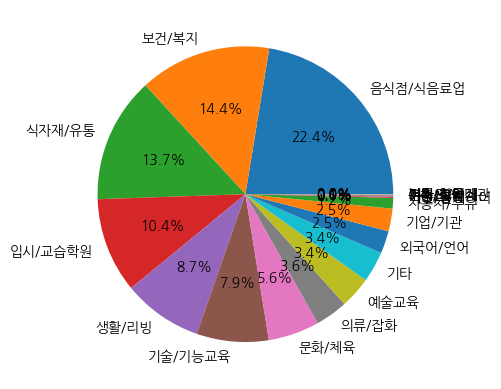

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# series 설정시 따로 구분하지 않으면 자체가 value
amount = sum_kind_sort_data.tolist() 
kind = sum_kind_sort_data.index.tolist()

plt.pie(amount, labels=kind, autopct='%.1f%%')
plt.show()

* 변수별 빈도, 비율, 평균, 중앙값, 표준편차 등 기초 통계량 분석

* 지역 데이터의 경우 지도로 표현

### 5. EDA 인사이트 도출 및 기록

* 발견한 주요 패턴, 이상값, 특이점 정리
    - 1. 생각보다 부자동네(강남,서초,성북)에서 상품권 소비가 많음
    <br>상품권의 소비구역이 서울권 전체라 타지역에서 받은 상품권이 사용되는 것으로 추정됨
    <br>발행 데이터가 있으면 확실히 확인 가능할 듯
    <br>상대적으로 서민동네인 '금천구', '구로구'가 소비의 낮은 순위
    <br>결국 돈이 좋은 상품과 환경으로 쏠림

    - 2. 사용 업종에서 음식점/식음료업이 1위 -> 지역과 연계하여 생각한다면 강남 음식점이 가장 많은 소비
    <br>대중음식점, 분식집, 카페, 제과점
    <br>원래 발행의 취지인 저소득층 소상공인은 오히려 소외될 수 있음
    <br>2위 보건/복지 -> 의원, 병원, 약국, 보건소

* 데이터 품질 문제 기록 (예: 입력 오류, 단위 문제 등)
    - 특정지역/업종의 결제 건수가 0인 데이터가 절반 가량(전처리에서 합침)

* 변경된 가설이나 추가로 필요한 데이터 정리
    - 김천은 학원 소비가 41%라는데 서울지역은 1위가 음식점<br>(지역별 차이 확인 필요)

* 다음 분석 단계(모델링, 시각화, 리포트 등)로의 계획 수립
    - 위경도 데이터와 연계하여 구별 소비액/업종 등 표현